In [12]:
# predict the next char
import tensorflow as tf
import numpy as np
import random
import pandas as pd
%matplotlib inline

In [13]:
def make_mini_batch(train_data, size_of_mini_batch, length_of_sequences):
    inputs  = np.empty(0)
    outputs = np.empty(0)
    for _ in range(size_of_mini_batch):
        index   = random.randint(0, len(train_data) - length_of_sequences - 1)
        inputs  = np.append(inputs, train_data[index:index + length_of_sequences])
        outputs = np.append(outputs, train_data[index + length_of_sequences + 1])
    inputs  = inputs.reshape(-1, length_of_sequences, 1)
    outputs = outputs.reshape(-1, 1)
    return (inputs, outputs)

In [14]:
def make_prediction_initial(train_data, index, length_of_sequences):
    return train_data[index:index + length_of_sequences], train_data[index + length_of_sequences + 1]

In [15]:
train_data_path             = "./char_rnn.ipynb"
num_of_char                 = 256
num_of_input_nodes          = 256
num_of_hidden_nodes         = 20
num_of_output_nodes         = 256
length_of_sequences         = 30
num_of_training_epochs      = 800
length_of_initial_sequences = 30
num_of_prediction_epochs    = 100
size_of_mini_batch          = 100
learning_rate               = 0.1
forget_bias                 = 1.0

In [16]:
#train_data = np.load(train_data_path)
f = open(train_data_path)
text = f.read()
f.close()
train_data = np.eye(num_of_char)[[ord(x) for x in text]]
train_data[:1]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [17]:
make_mini_batch(train_data, size_of_mini_batch, length_of_sequences)

(array([[[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],
 
        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],
 
        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],
 
        ..., 
        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],
 
        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],
 
        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]]]), array([[ 0.],
        [ 0.],
        [ 0.],
        ..., 
        [ 0.],
        [ 0.],
        [ 0.]]))

In [13]:
#optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

with tf.Graph().as_default():
    input_ph      = tf.placeholder(tf.float32, [None, length_of_sequences, num_of_input_nodes], name="input")
    supervisor_ph = tf.placeholder(tf.float32, [None, num_of_output_nodes], name="supervisor")

    with tf.name_scope("inference") as scope:
        weight1_var = tf.Variable(tf.truncated_normal([num_of_input_nodes, num_of_hidden_nodes], stddev=0.1), name="weight1")
        weight2_var = tf.Variable(tf.truncated_normal([num_of_hidden_nodes, num_of_output_nodes], stddev=0.1), name="weight2")
        bias1_var   = tf.Variable(tf.truncated_normal([num_of_hidden_nodes], stddev=0.1), name="bias1")
        bias2_var   = tf.Variable(tf.truncated_normal([num_of_output_nodes], stddev=0.1), name="bias2")

        weight1_hist = tf.histogram_summary("layer1/weights", weight1_var)
        weight2_hist = tf.histogram_summary("layer2/weights", weight2_var)
        bias1_hist = tf.histogram_summary("layer1/biases", bias1_var)
        bias2_hist = tf.histogram_summary("layer2/biases", bias2_var)
        
        # pre rnn
        in1 = tf.transpose(input_ph, [1, 0, 2])         # (batch, sequence, data) -> (sequence, batch, data)
        in2 = tf.reshape(in1, [-1, num_of_input_nodes]) # (sequence, batch, data) -> (sequence * batch, data)
        in3 = tf.matmul(in2, weight1_var) + bias1_var
        in4 = tf.split(0, length_of_sequences, in3)     # sequence * (batch, data)

        _cell = tf.nn.rnn_cell.BasicLSTMCell(num_of_hidden_nodes, forget_bias=forget_bias, state_is_tuple=True)
        cell = tf.nn.rnn_cell.MultiRNNCell([_cell] * 2, state_is_tuple=True)
        istate_ph = cell.zero_state(size_of_mini_batch, tf.float32)
        rnn_output, states_op = tf.nn.rnn(cell, in4, dtype=tf.float32)
        
        # post rnn
        output_op = tf.matmul(rnn_output[-1], weight2_var) + bias2_var

    with tf.name_scope("loss") as scope:
        square_error = tf.reduce_mean(tf.square(output_op - supervisor_ph))
        loss_op      = square_error
        tf.scalar_summary("loss", loss_op)

    with tf.name_scope("training") as scope:
        training_op = optimizer.minimize(loss_op)

    summary_op = tf.merge_all_summaries()
    init = tf.initialize_all_variables()

    with tf.Session() as sess:
        saver = tf.train.Saver()
        summary_writer = tf.train.SummaryWriter("data", graph=sess.graph)
        # random seed fix
        random.seed(0)
        np.random.seed(0)
        tf.set_random_seed(0)
        # init variables
        sess.run(init)

        for epoch in range(num_of_training_epochs):
            inputs, supervisors = make_mini_batch(train_data, size_of_mini_batch, length_of_sequences)
            state = sess.run(istate_ph)

            train_dict = {
                input_ph:      inputs,
                supervisor_ph: supervisors,
            }
            sess.run(training_op, feed_dict=train_dict)

            if (epoch + 1) % 10 == 0:
                summary_str, train_loss = sess.run([summary_op, loss_op], feed_dict=train_dict)
                summary_writer.add_summary(summary_str, epoch)
                print("train#%d, train loss: %e" % (epoch + 1, train_loss))

        inputs  = make_prediction_initial(train_data, 0, length_of_initial_sequences)
        outputs = np.empty(0)

        print("initial:", inputs)
        np.save("initial.npy", inputs)

        istate_ph = cell.zero_state(1, tf.float32)
        sess.run(istate_ph)

        for epoch in range(num_of_prediction_epochs):
            pred_dict = {
                input_ph:  inputs.reshape((1, length_of_sequences, 1)),
            }
            output, states = sess.run([output_op, states_op], feed_dict=pred_dict)
            print("prediction#%d, output: %f" % (epoch + 1, output))

            inputs  = np.delete(inputs, 0)
            inputs  = np.append(inputs, output)
            outputs = np.append(outputs, output)
        
        print("outputs:", outputs)
        np.save("output.npy", outputs)

        saver.save(sess, "data/model")

train#10, train loss: 1.130664e+01
train#20, train loss: 2.199475e+00
train#30, train loss: 1.297198e+00
train#40, train loss: 1.323074e+00
train#50, train loss: 1.067035e+00
train#60, train loss: 1.075136e+00
train#70, train loss: 1.296112e+00
train#80, train loss: 1.106902e+00
train#90, train loss: 1.050724e+00
train#100, train loss: 9.987417e-01
train#110, train loss: 1.008461e+00
train#120, train loss: 1.008897e+00
train#130, train loss: 1.086520e+00
train#140, train loss: 9.178229e-01
train#150, train loss: 1.347715e+00
train#160, train loss: 8.787076e-01
train#170, train loss: 1.278637e+00
train#180, train loss: 1.336107e+00
train#190, train loss: 1.077739e+00
train#200, train loss: 1.081687e+00
train#210, train loss: 1.183185e+00
train#220, train loss: 1.112393e+00
train#230, train loss: 1.146985e+00
train#240, train loss: 9.048830e-01
train#250, train loss: 9.921404e-01
train#260, train loss: 1.139585e+00
train#270, train loss: 7.952631e-01
train#280, train loss: 7.340971e-01
t

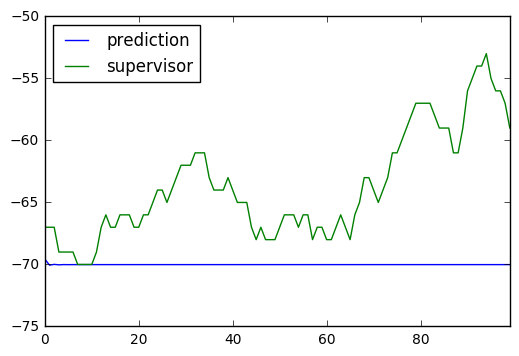

In [15]:
output = np.load('output.npy')
df = pd.DataFrame({'supervisor': train_data[length_of_initial_sequences:length_of_initial_sequences+num_of_prediction_epochs,1], 'prediction': output})
df.plot()